# Setup code

In [7]:
import sys
import calico
from collections import defaultdict
import numpy as np
import cv2
import os
import csv
from typing import Dict, Tuple, List
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import yaml

class EurocDataset:
  def __init__(self, dataset_path : str):
    dataset_path = os.path.expanduser(dataset_path)
    self._cam0_image_path = os.path.join(dataset_path, "cam0", "data")
    cam0_image_stamps_path = os.path.join(dataset_path, "cam0", "data.csv")
    self._cam1_image_path = os.path.join(dataset_path, "cam1", "data")
    cam1_image_stamps_path = os.path.join(dataset_path, "cam1", "data.csv")
    imu_path = os.path.join(dataset_path, "imu0", "data.csv")
    
    self._stamp_to_cam0_image_path = self._parse_image_csv(cam0_image_stamps_path)
    self._stamp_to_cam1_image_path = self._parse_image_csv(cam1_image_stamps_path)
    self._imu_data = self._parse_imu_csv(imu_path)

  @property
  def cam0_stamps(self):
    return sorted(self._stamp_to_cam0_image_path.keys())

  @property
  def cam1_stamps(self):
    return sorted(self._stamp_to_cam1_image_path.keys())

  @property
  def imu_stamps(self):
    return sorted(self._imu_data.keys())

  def get_cam0_image(self, stamp : float) -> np.ndarray:
    """Get the image for camera 0 at a specific timestamp as an ndarray.
    Args:
      stamp:
        Valid timestamp in seconds. Raises a ValueError if stamp is invalid.
    Returns:
      ndarray of the image in grayscale.
    """
    if stamp not in self._stamp_to_cam0_image_path.keys():
      raise ValueError(f"Invalid timestamp {stamp}")
    img_fname = self._stamp_to_cam0_image_path.get(stamp)
    full_img_path = os.path.join(self._cam0_image_path, img_fname)
    return cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)

  def get_cam1_image(self, stamp : float) -> np.ndarray:
    """Get the image for camera 1 at a specific timestamp as an ndarray.
    Args:
      stamp:
        Valid timestamp in seconds. Raises a ValueError if stamp is invalid.
    Returns:
      ndarray of the image in grayscale.
    """
    if stamp not in self._stamp_to_cam0_image_path.keys():
      raise ValueError(f"Invalid timestamp {stamp}")
    img_fname = self._stamp_to_cam1_image_path.get(stamp)
    full_img_path = os.path.join(self._cam1_image_path, img_fname)
    return cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)

  def get_imu_data(self, stamp : float) -> Tuple[np.ndarray, np.ndarray]:
    """Get the IMU data at a specific timestamp as a tuple.
    Args:
      stamp:
        Valid timestamp in seconds. Raises a ValueError if stamp is invalid.
    Returns:
      Tuple of gyro and accel values.
    """
    if stamp not in self._imu_data.keys():
      raise ValueError(f"Invalid timestamp {stamp}")
    return self._imu_data[stamp]["gyro"], self._imu_data[stamp]["accel"]
    
  def _parse_imu_csv(
      self,
      stamp_to_imu_data : str
  ) -> Dict[float, Dict[str, np.ndarray]]:
    stamp_to_imu = defaultdict(lambda : defaultdict(np.ndarray))
    with open(stamp_to_imu_data, "r") as f:
      reader = csv.reader(f)
      next(reader)
      for row in reader:
        stamp_ns, wx, wy, wz, ax, ay, az = row
        stamp_s = float(stamp_ns) * 1e-9
        omega = np.array([wx, wy, wz])
        accel = np.array([ax, ay, az])
        stamp_to_imu[stamp_s]["gyro"] = omega
        stamp_to_imu[stamp_s]["accel"] = accel
    return stamp_to_imu

  def _parse_image_csv(
      self,
      stamp_to_image_file_path : str
  ) -> Dict[float, str]:
    # Read in csv.
    stamp_to_image_path = dict()
    with open(stamp_to_image_file_path, "r") as f:
      reader = csv.reader(f)
      next(reader)
      for row in reader:
        stamp_ns, image_file_name = row
        stamp_s = float(stamp_ns) * 1e-9
        stamp_to_image_path[stamp_s] = image_file_name
    return stamp_to_image_path

# Load in the data

For this demo, we use the EuRoC IMU-camera calibration dataset. Download the [zip file](http://robotics.ethz.ch/~asl-datasets/ijrr_euroc_mav_dataset/calibration_datasets/cam_april/cam_april.zip) and extract the contents to your home directory under `imu_april`, or run the following:

```
cd ~
wget http://robotics.ethz.ch/~asl-datasets/ijrr_euroc_mav_dataset/calibration_datasets/imu_april/imu_april.zip
unzip imu_april.zip -d imu_april
```

In the step below, we load in this dataset, and run the AprilGrid detector on all the left camera images.

In [8]:
# Read in the dataset.
imu_cal_base_path = "~/imu_april/mav0/"
chart_definition_path = "~/imu_april/april_6x6.yaml"
imu_cal_dataset = EurocDataset(imu_cal_base_path)
detector = calico.AprilGridDetector(os.path.expanduser(chart_definition_path))

cam0_stamps = imu_cal_dataset.cam0_stamps
imu_stamps = imu_cal_dataset.imu_stamps

topic_left = "cam0"
all_detections = {
     topic_left: [],
}

# Run april grid detection on left camera images.
print("Processing cam0...")
for im_count, stamp in enumerate(cam0_stamps):
    print(f'\r{100.0 * (im_count + 1) / len(cam0_stamps):.1f}%:'
          f' Processed {im_count + 1} of {len(cam0_stamps)} images.', end='')
    im = imu_cal_dataset.get_cam0_image(stamp)
    detections = detector.Detect(im)
    if len(detections) == 0:
        continue
    all_detections[topic_left].append((stamp, im_count, detections))

Processing cam0...
100.0%: Processed 1439 of 1439 images.

# Create the trajectory

Next, we create the trajectory of our sensor rig using the camera detections. In order to constrain the problem well, we define the sensorrig trajectory as being co-located with the IMU. We extract chart-from-camera poses from the left camera detections, then rotate each pose such that it roughly matches the expected orientation as per this drawing:

![](https://projects.asl.ethz.ch/datasets/lib/exe/fetch.php?cache=&media=platform.jpg)

In [9]:
# Load in chart detector.
chart_rigid_body = detector.GetRigidBodyDefinition()
chart_rigid_body.world_pose_is_constant = True
chart_rigid_body.model_definition_is_constant = True
    
left_detections = [detections[2] for detections in all_detections[topic_left]]
_, R_chart_left, t_chart_left = calico.InitializePinholeAndPoses( 
    left_detections, chart_rigid_body.model_definition)

# Create trajectory where IMU is at origin of sensorrig.
R_left_imu = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1]
])
stamps = [detections[0] for detections in all_detections[topic_left]]
poses_chart_sensorrig = {}
for stamp, R_chart_left_i, t_chart_left_i in zip(stamps, R_chart_left, t_chart_left):
    R_chart_imu = np.dot(R_chart_left_i, R_left_imu)
    pose_chart_sensorrig = calico.Pose3d()
    pose_chart_sensorrig.rotation = R.from_matrix(R_chart_imu).as_quat()[[3, 0, 1, 2]]
    pose_chart_sensorrig.translation = t_chart_left_i
    poses_chart_sensorrig[stamp] = pose_chart_sensorrig
trajectory_chart_sensorrig = calico.Trajectory()
trajectory_chart_sensorrig.FitSpline(poses_chart_sensorrig, knot_frequency=20)

# Create sensors and world model
Our problem consists of a camera, accelerometer, and gyroscope. We assume that the accelerometer and gyroscope are co-located and fixed with respect to each other, and that the left camera is on an unknown lever arm. Furthermore, we assume that the accelerometer and gyroscope intrinsics are uncalibrated, and the left camera intrinsics calibration we pulled from the multi-camera calibration demo.

We want to apply weights to the residuals based on sensor noise. The EuRoC calibration dataset comes with the noise densities of the gyroscope and accelerometer. We ignore the random walk noise values as we're going to assume constant bias in this problem.

Based on the first image of the dataset, the calibration chart is held upright with the y-axis pointing up. Since our world model is currently defined as being co-located with the chart, we set gravity to be a vector pointing downward in the y direction, i.e. into the ground.

In [10]:
# Create camera.
left_intrinsics = [
  4.57289026e+02, 3.65831778e+02, 2.48848429e+02,
  -3.16346544e-03, 4.08854709e-02, -5.34498200e-02, 2.34848287e-02]
pose_sensorrig_left = calico.Pose3d()
pose_sensorrig_left.rotation = R.from_matrix(R_left_imu.T).as_quat()[[3, 0, 1, 2]]
camera_model_type = calico.CameraIntrinsicsModel.kKannalaBrandt
camera_left = calico.Camera()
camera_left.SetName(topic_left)
for stamp, seq, detections in all_detections[topic_left]:
    measurements = calico.DetectionsToCameraMeasurements(detections, stamp, seq)
    camera_left.AddMeasurements(measurements)
camera_left.SetModel(camera_model_type)
#camera_left.SetLossFunction(calico.LossFunctionType.kCauchy, 1.0)
camera_left.SetIntrinsics(left_intrinsics)
camera_left.SetExtrinsics(pose_sensorrig_left)
camera_left.SetMeasurementNoise(0.1)
camera_left.EnableExtrinsicsEstimation(True)
camera_left.EnableLatencyEstimation(True)

# Create IMU.
imu_noise_info_path = os.path.expanduser(os.path.join(imu_cal_base_path, "imu0/sensor.yaml"))
with open(imu_noise_info_path, "r") as f:
  imu_noise_info = yaml.safe_load(f)
imu_rate = imu_noise_info["rate_hz"]

accel_sigma = imu_noise_info["accelerometer_noise_density"] * np.sqrt(imu_rate)
accel_model_type = calico.AccelerometerIntrinsicsModel.kAccelerometerVectorNav
accel_intrinsics = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
accel = calico.Accelerometer()
accel.SetModel(accel_model_type)
#accel.SetLossFunction(calico.LossFunctionType.kHuber, 1.0)
accel.SetIntrinsics(accel_intrinsics)
accel.SetMeasurementNoise(accel_sigma)

gyro_sigma = imu_noise_info["gyroscope_noise_density"] * np.sqrt(imu_rate)
gyro_model_type = calico.GyroscopeIntrinsicsModel.kGyroscopeVectorNav
gyro_intrinsics = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
gyro = calico.Gyroscope()
gyro.SetModel(gyro_model_type)
#gyro.SetLossFunction(calico.LossFunctionType.kHuber, 1.0)
gyro.SetIntrinsics(gyro_intrinsics)
gyro.SetMeasurementNoise(gyro_sigma)

accel_measurements, gyro_measurements = list(), list()
for i, stamp in enumerate(imu_stamps):
    gyro_data, accel_data = imu_cal_dataset.get_imu_data(stamp)
    accel_meas = calico.AccelerometerMeasurement()
    accel_meas.id.stamp = stamp
    accel_meas.id.sequence = i
    accel_meas.measurement = accel_data
    accel_measurements.append(accel_meas)

    gyro_meas = calico.GyroscopeMeasurement()
    gyro_meas.id.stamp = stamp
    gyro_meas.id.sequence = i
    gyro_meas.measurement = gyro_data
    gyro_measurements.append(gyro_meas)
accel.AddMeasurements(accel_measurements)
gyro.AddMeasurements(gyro_measurements)

accel.EnableIntrinsicsEstimation(True)
gyro.EnableIntrinsicsEstimation(True)

# Create world model. Gravity is pointing in the negative y direction based on the data collection setup.
world_model = calico.WorldModel()
world_model.AddRigidBody(chart_rigid_body)
world_model.SetGravity([0, -9.80655, 0])

# Run the optimization
This step can take several minutes.

In [11]:
# Optimize.
optimizer = calico.BatchOptimizer()
optimizer.AddSensor(camera_left)
optimizer.AddSensor(gyro)
optimizer.AddSensor(accel)
optimizer.AddWorldModel(world_model)
optimizer.AddTrajectory(trajectory_chart_sensorrig)

options = calico.DefaultSolverOptions()
options.num_threads = 4
options.max_num_iterations = 150
options.minimizer_progress_to_stdout = True

summary = optimizer.Optimize(options)

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.616876e+11    0.00e+00    3.88e+11   0.00e+00   0.00e+00  1.00e+04        0    1.46e+00    1.85e+00
   1  1.797693e+308   -1.80e+308    3.88e+11   1.66e+03  -1.80e+308  5.00e+03        1    5.77e+00    7.62e+00
   2  1.797693e+308   -1.80e+308    3.88e+11   1.74e+03  -1.80e+308  1.25e+03        1    5.60e+00    1.32e+01
   3  1.797693e+308   -1.80e+308    3.88e+11   2.02e+03  -1.80e+308  1.56e+02        1    5.58e+00    1.88e+01
   4  1.797693e+308   -1.80e+308    3.88e+11   3.13e+03  -1.80e+308  9.77e+00        1    5.48e+00    2.43e+01
   5  3.460107e+10    3.27e+11    1.73e+11   1.74e+03   9.13e-01  2.25e+01        1    7.02e+00    3.13e+01
   6  3.120394e+09    3.15e+10    1.21e+10   3.54e+03   9.51e-01  6.74e+01        1    7.09e+00    3.84e+01
   7  1.330889e+09    1.79e+09    2.08e+09   8.85e+03   8.17e-01  9.04e+01        1    7.05e+00    4.54e+01
   8  1.050904e+

W0510 07:54:12.784026 806620 trust_region_minimizer.cc:770] Step failed to evaluate. Treating it as a step with infinite cost
W0510 07:54:18.381731 806620 trust_region_minimizer.cc:770] Step failed to evaluate. Treating it as a step with infinite cost
W0510 07:54:23.960376 806620 trust_region_minimizer.cc:770] Step failed to evaluate. Treating it as a step with infinite cost
W0510 07:54:29.437808 806620 trust_region_minimizer.cc:770] Step failed to evaluate. Treating it as a step with infinite cost


 8.71e+02   9.66e-01  2.69e+01        1    6.92e+00    1.24e+02
  20  2.496014e+08    4.18e+07    1.85e+09   7.76e+03   5.77e-01  2.70e+01        1    6.97e+00    1.30e+02
  21  1.803421e+08    6.93e+07    2.53e+08   1.33e+03   9.06e-01  5.83e+01        1    7.03e+00    1.38e+02
  22  1.435889e+08    3.68e+07    4.14e+07   3.06e+02   1.04e+00  1.75e+02        1    7.02e+00    1.45e+02
  23  9.322838e+07    5.04e+07    1.49e+08   2.28e+03   1.11e+00  5.24e+02        1    7.05e+00    1.52e+02
  24  3.847906e+07    5.47e+07    2.53e+08   3.95e+03   1.09e+00  1.57e+03        1    7.01e+00    1.59e+02
  25  2.514652e+07    1.33e+07    2.00e+08   1.22e+03   9.79e-01  4.72e+03        1    7.04e+00    1.66e+02
  26  2.056388e+07    4.58e+06    7.38e+08   4.17e+01   8.78e-01  8.32e+03        1    7.06e+00    1.73e+02
  27  1.662277e+07    3.94e+06    1.31e+09   3.23e+00   8.80e-01  1.48e+04        1    7.04e+00    1.80e+02
  28  1.341617e+07    3.21e+06    1.77e+09   4.05e+00   7.25e-01  1.63e+

Gyro intrinsics:
[ 0.98911003  0.97406921  0.96149283 -0.07128753  0.12559703  0.0390135
  0.24372345 -0.14193668 -0.23929987 -0.0020605   0.02414004  0.07684676]
Accel intrinsics:
[ 0.98911003  0.97406921  0.96149283 -0.07128753  0.12559703  0.0390135
  0.24372345 -0.14193668 -0.23929987 -0.0020605   0.02414004  0.07684676]
Camera extrinsics:
q - [ 0.72467587  0.03151285 -0.12196129  0.67747861]
t - [-0.00852676 -0.07832207  0.03413271]
Final RMSE
4.364686711533984


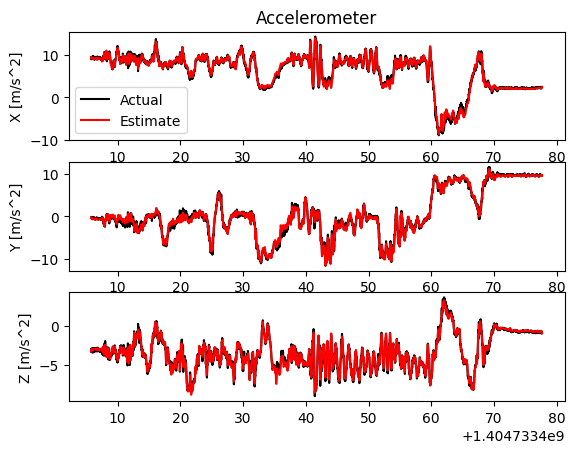

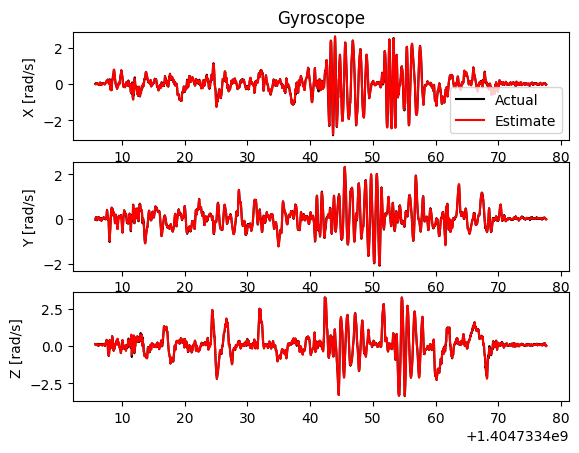

In [12]:
print(f"Gyro intrinsics:\n{gyro.GetIntrinsics()}")
print(f"Accel intrinsics:\n{gyro.GetIntrinsics()}")
print(f"Camera extrinsics:\nq - {camera_left.GetExtrinsics().rotation}\nt - {camera_left.GetExtrinsics().translation}")

print('Final RMSE')
print(np.sqrt(summary.final_cost / summary.num_residuals))

accel_proj = accel.Project(imu_stamps, trajectory_chart_sensorrig, world_model)
plt.figure()
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(imu_stamps, [meas.measurement[i] for meas in accel_measurements], "k-", label="Actual")
    plt.plot(imu_stamps, [meas.measurement[i] for meas in accel_proj], "r-", label="Estimate")
    plt.ylabel(chr(i+88) + " [m/s^2]")
    if i == 0:
        plt.legend()
        plt.title("Accelerometer")
gyro_proj = gyro.Project(imu_stamps, trajectory_chart_sensorrig, world_model)
plt.figure()
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(imu_stamps, [meas.measurement[i] for meas in gyro_measurements], "k-", label="Actual")
    plt.plot(imu_stamps, [meas.measurement[i] for meas in gyro_proj], "r-", label="Estimate")
    plt.ylabel(chr(i+88) + " [rad/s]")
    if i == 0:
        plt.legend()
        plt.title("Gyroscope")